In [1]:
import json
import torch
import warnings
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt

from vocab import Vocab
from model import Transformer
from test import greedy_decode
from dataset import read_corpus
from utils import subsequent_mask
from model import PositionalEncoding

warnings.filterwarnings("ignore")

c:\Users\wf123\.conda\envs\py38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([1, 10, 64])


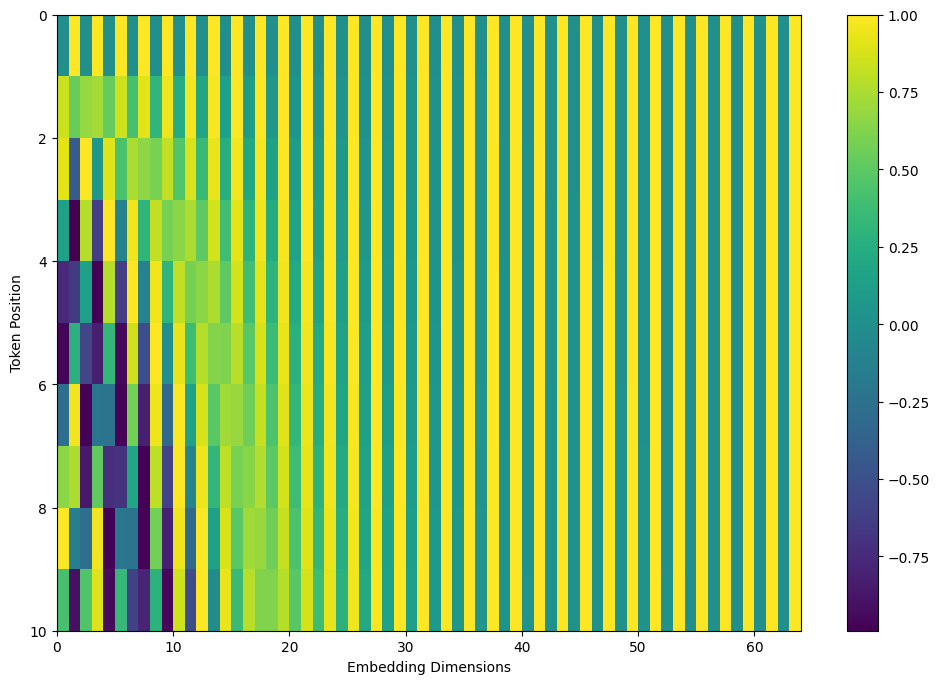

In [2]:
max_len = 10
d_model = 64

pos_encoding = PositionalEncoding(d_model, 0, max_len)
pe = pos_encoding.pe
print(pe.shape)

plt.figure(figsize=(12, 8))
plt.pcolormesh(pe[0], cmap='viridis')
plt.xlabel('Embedding Dimensions')
plt.xlim((0, d_model))
plt.ylim((max_len,0))
plt.ylabel('Token Position')
plt.colorbar()
plt.show()

In [2]:
def mtx2df(m, max_row, max_col, row_tokens, col_tokens):
    "convert a dense matrix to a data frame with row and column indices"
    return pd.DataFrame(
        [
            (
                r,
                c,
                float(m[r, c]),
                "%.3d %s"
                % (r, row_tokens[r] if len(row_tokens) > r else "<pad>"),
                "%.3d %s"
                % (c, col_tokens[c] if len(col_tokens) > c else "<pad>"),
            )
            for r in range(m.shape[0])
            for c in range(m.shape[1])
            if r < max_row and c < max_col
        ],
        # if float(m[r,c]) != 0 and r < max_row and c < max_col],
        columns=["row", "column", "value", "row_token", "col_token"],
    )


def attn_map(attn, layer, head, row_tokens, col_tokens, max_dim=30):
    df = mtx2df(
        attn[0, head].data,
        max_dim,
        max_dim,
        row_tokens,
        col_tokens,
    )
    return (
        alt.Chart(data=df)
        .mark_rect()
        .encode(
            x=alt.X("col_token", axis=alt.Axis(title="")),
            y=alt.Y("row_token", axis=alt.Axis(title="")),
            color="value",
            tooltip=["row", "column", "value", "row_token", "col_token"],
        )
        .properties(height=400, width=400)
        .interactive()
    )

In [3]:
def get_encoder(model, layer):
    return model.encoder.layers[layer].self_attn.attn_weights


def get_decoder_self(model, layer):
    return model.decoder.layers[layer].self_attn.attn_weights


def get_decoder_cross(model, layer):
    return model.decoder.layers[layer].cross_attn.attn_weights

In [4]:
def visualize_layer(model, layer, getter_fn, ntokens, row_tokens, col_tokens):
    # ntokens = last_example[0].ntokens
    attn = getter_fn(model, layer)
    n_heads = attn.shape[1]
    charts = [
        attn_map(
            attn,
            0,
            h,
            row_tokens=row_tokens,
            col_tokens=col_tokens,
            max_dim=ntokens,
        )
        for h in range(n_heads)
    ]
    assert n_heads == 8
    return alt.vconcat(
        charts[0]
        # | charts[1]
        | charts[2]
        # | charts[3]
        | charts[4]
        # | charts[5]
        | charts[6]
        # | charts[7]
        # layer + 1 due to 0-indexing
    ).properties(title="Layer %d" % (layer + 1))

In [5]:
def viz_encoder_self_attn(model, src_tokens):
    
    layer_viz = [
        visualize_layer(
            model, layer, get_encoder, len(src_tokens), src_tokens, src_tokens
        )
        for layer in range(6)
    ]
    return alt.hconcat(
        layer_viz[0]
        & layer_viz[1]
        & layer_viz[2]
        & layer_viz[3]
        & layer_viz[4]
        & layer_viz[5]
    )

def viz_decoder_self_attn(model, tgt_tokens):

    layer_viz = [
        visualize_layer(
            model,
            layer,
            get_decoder_self,
            len(tgt_tokens),
            tgt_tokens,
            tgt_tokens,
        )
        for layer in range(6)
    ]
    return alt.hconcat(
        layer_viz[0]
        & layer_viz[1]
        & layer_viz[2]
        & layer_viz[3]
        & layer_viz[4]
        & layer_viz[5]
    )

def viz_decoder_cross_attn(model, src_tokens, tgt_tokens):

    layer_viz = [
        visualize_layer(
            model,
            layer,
            get_decoder_cross,
            max(len(src_tokens), len(tgt_tokens)),
            src_tokens,
            tgt_tokens,
        )
        for layer in range(6)
    ]
    return alt.hconcat(
        layer_viz[0]
        & layer_viz[1]
        & layer_viz[2]
        & layer_viz[3]
        & layer_viz[4]
        & layer_viz[5]
    )

In [6]:
model_path = "../../transformer_old/outputs/20230708-183125/zh_en_model__final.pth"
model = Transformer.load(model_path)

In [7]:
src_sp_model_path = "../data/src.model"
tgt_sp_model_path = "../data/tgt.model"
test_src_file_path = "../data/zh_en_data/test.zh"
test_tgt_file_path = "../data/zh_en_data/test.en"
test_src_data = read_corpus(test_src_file_path, 'src', src_sp_model_path)
test_tgt_data = read_corpus(test_tgt_file_path, 'tgt', tgt_sp_model_path)
vocab_path = "../data/vocab.json"
vocab_data = json.load(open(vocab_path))
src_word2id = vocab_data["src_word2id"]
tgt_word2id = vocab_data["tgt_word2id"]
src_vocab = Vocab(src_word2id)
tgt_vocab = Vocab(tgt_word2id)

In [8]:
df_test = pd.DataFrame()
df_test["src"] = test_src_data
df_test["tgt"] = test_tgt_data
df_test["src_len"] = df_test["src"].apply(lambda x: len(x))
df_test["tgt_len"] = df_test["tgt"].apply(lambda x: len(x))
df_test["diff"] = abs(df_test["src_len"] - df_test["tgt_len"])
df_test = df_test.sort_values(by="diff").reset_index(drop=True)
dft1 = df_test[df_test["src_len"].apply(lambda x: x >= 6 and x <= 20)].reset_index(drop=True)

In [9]:
idx = 5
src_words = dft1.iloc[idx]["src"]
tgt_words = dft1.iloc[idx]["tgt"]
src_text = "".join(src_words).replace("▁", " ")
tgt_text = "".join(tgt_words[1:-1]).replace("▁", " ")
src_ids = [[src_vocab.word2id(x) for x in src_words]]
src_ids = torch.LongTensor(src_ids)
max_len = len(tgt_words) + 4
start_id = tgt_vocab.start_id
end_id = tgt_vocab.end_id
y_pred = greedy_decode(model, src_ids, None, max_len, start_id, end_id)
y_pred = y_pred[0].tolist()
trans_words = [tgt_vocab.id2word(x) for x in y_pred]
trans_text = "".join(trans_words).replace("▁", " ")

In [10]:
print("src: ", src_text)
print("tgt: ", tgt_text)
print("pre: ", trans_text)

src:   文字结构更加紧凑,简练,内容也更加连贯。
tgt:   it was better structured, simpler and more consistent.
pre:  <s> the text structure has been more tight, and the content is even more consistent.</s>


In [11]:
viz_encoder_self_attn(model, src_words)

alt.HConcatChart(...)

In [12]:
viz_decoder_self_attn(model, trans_words)

alt.HConcatChart(...)

In [13]:
viz_decoder_cross_attn(model, src_words, trans_words)

alt.HConcatChart(...)